# Stage 3: NLOS Bias Prediction
## Multi-Model Pipeline — Single-Bounce Ranging Error Mitigation

**Purpose**: Given a single-bounce NLOS signal (filtered by Stage 2), predict the **NLOS bias** — the extra path length caused by the signal reflecting off a surface instead of traveling directly.

**Why this matters**: In single-bounce NLOS, the UWB measures the reflected path (d1 + d2) instead of the true direct distance. By predicting the bias, we can correct the measurement:
```
d_corrected = d_UWB - predicted_bias
```

**Ground truth** (physically measured):
| Setup | d_direct | d1+d2 (bounce) | Bias = (d1+d2) - d_direct |
|-------|----------|----------------|---------------------------|
| 7.79m | 7.79m | 12.79m | **5.00m** |
| 10.77m | 10.77m | 16.09m | **5.32m** |
| 14m | 14.00m | 16.80m | **2.80m** |

**Approach**: The Stage 1 PI-HLNN serves as a **shared encoder** — its learned 48-dim hidden state captures CIR temporal dynamics. We freeze the LNN and use these embeddings as input to a Random Forest regressor for bias prediction.

**Architecture**: Frozen PI-HLNN encoder → 48-dim embeddings → Random Forest Regressor

**Pipeline**: Stage 1 (LNN → LOS/NLOS) → Stage 2 (LNN embeddings → RF → single/multi bounce) → **Stage 3 (LNN embeddings → RF → NLOS bias → corrected distance)**

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from scipy.signal import find_peaks
from scipy.stats import kurtosis as scipy_kurtosis
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import os

# ==========================================
# CONFIGURATION
# ==========================================
CONFIG = {
    # ROI alignment (same as Stage 1)
    "search_start": 740,
    "search_end": 890,
    # Peak detection (same as Stage 2)
    "peak_prominence": 0.20,
    "peak_min_distance": 5,
    # Single-bounce filter (same as Stage 2)
    "single_bounce_max_peaks": 2,
    # Random Forest
    "n_estimators": 200,
    "max_depth": None,
    "min_samples_split": 5,
    "min_samples_leaf": 2,
    # Split
    "test_ratio": 0.30,
    "seed": 42,
}

# Hand-crafted features — used ONLY for auto-labeling (Num_Peaks) & EDA.
# The model input is 48-dim LNN embeddings, NOT these features.
FEATURE_NAMES = [
    "Rise_Time", "Mean_Excess_Delay", "RMS_Delay_Spread"
]

np.random.seed(CONFIG["seed"])
print(f"Config: {CONFIG}")
print(f"Auto-label features: {FEATURE_NAMES} (for EDA/validation only)")
print(f"Model input: 48-dim LNN embeddings (from frozen Stage 1 PI-HLNN)")

Config: {'search_start': 740, 'search_end': 890, 'peak_prominence': 0.2, 'peak_min_distance': 5, 'single_bounce_max_peaks': 2, 'n_estimators': 200, 'max_depth': None, 'min_samples_split': 5, 'min_samples_leaf': 2, 'test_ratio': 0.3, 'seed': 42}
Auto-label features: ['Rise_Time', 'Mean_Excess_Delay', 'RMS_Delay_Spread'] (for EDA/validation only)
Model input: 48-dim LNN embeddings (from frozen Stage 1 PI-HLNN)


---
## Section 2: Data Loading, Feature Extraction & Target Assignment

1. Load NLOS samples from training dataset
2. Extract CIR-derived physics features
3. Filter to **single-bounce only** using peak count auto-labeling
4. Target: **NLOS bias** = (d1+d2) - d_direct, physically measured per setup

**Stage 3 uses 3 CIR TIMING features** — these describe the delay characteristics that correlate with how much extra distance the NLOS signal traveled:

| Feature | Relevance to NLOS Bias |
|---------|------------------------|
| Rise_Time | Longer rise = more indirect path = larger bias |
| Mean_Excess_Delay | Directly proportional to extra path length |
| RMS_Delay_Spread | Wider spread = more multipath delay = larger bias |

**Features NOT used by Stage 3** (reserved for Stage 2):
- Kurtosis, Power_Ratio — these are **shape** features for bounce type detection, not bias magnitude
- Num_Peaks — excluded because it IS the auto-label source (data leakage)

In [9]:
# ==========================================
# ROI ALIGNMENT (reused from Stage 1 & 2)
# ==========================================
def get_roi_alignment(sig, search_start=CONFIG["search_start"],
                      search_end=CONFIG["search_end"]):
    """Find leading edge by backtracking from peak."""
    region = sig[search_start:search_end]
    if len(region) == 0:
        return np.argmax(sig)
    
    peak_local = np.argmax(region)
    peak_idx = search_start + peak_local
    peak_val = sig[peak_idx]
    
    noise_section = sig[:search_start]
    if len(noise_section) > 10:
        noise_mean = np.mean(noise_section)
        noise_std = np.std(noise_section)
        threshold = max(noise_mean + 3 * noise_std, 0.05 * peak_val)
    else:
        threshold = 0.05 * peak_val
    
    leading_edge = peak_idx
    for i in range(peak_idx, max(search_start - 20, 0), -1):
        if sig[i] < threshold:
            leading_edge = i + 1
            break
    
    return leading_edge


# ==========================================
# CIR FEATURE EXTRACTION (reused from Stage 2)
# ==========================================
def extract_cir_features(sig, leading_edge, config=CONFIG):
    """
    Extract 6 physics features from RXPACC-normalized CIR.
    All derived from the CIR waveform + estimated leading edge.
    """
    peak_idx = np.argmax(sig[config["search_start"]:config["search_end"]]) + config["search_start"]
    peak_val = sig[peak_idx]
    
    # 1. Kurtosis
    win_start = max(0, peak_idx - 10)
    win_end = min(len(sig), peak_idx + 30)
    window = sig[win_start:win_end]
    kurt = scipy_kurtosis(window, fisher=True) if len(window) > 4 else 0.0
    
    # 2. Rise Time
    rise_time = float(peak_idx - leading_edge)
    
    # 3 & 4. PDP-based: Mean Excess Delay & RMS Delay Spread
    pdp_start = max(0, leading_edge)
    pdp_sig = sig[pdp_start:min(pdp_start + 150, len(sig))]
    pdp = pdp_sig ** 2
    total_pdp = np.sum(pdp)
    
    if total_pdp > 0:
        times = np.arange(len(pdp), dtype=float)
        mean_delay = np.sum(pdp * times) / total_pdp
        second_moment = np.sum(pdp * times ** 2) / total_pdp
        rms_spread = np.sqrt(max(0, second_moment - mean_delay ** 2))
    else:
        mean_delay = 0.0
        rms_spread = 0.0
    
    # 5. Power Ratio
    fp_start = max(0, leading_edge - 1)
    fp_end = min(len(sig), leading_edge + 2)
    fp_energy = np.sum(sig[fp_start:fp_end] ** 2)
    total_energy = np.sum(sig ** 2)
    power_ratio = fp_energy / total_energy if total_energy > 0 else 0.0
    
    # 6. Number of Peaks
    roi_start = max(0, leading_edge - 5)
    roi_end = min(len(sig), leading_edge + 120)
    roi = sig[roi_start:roi_end]
    
    if len(roi) > 0 and np.max(roi) > 0:
        roi_norm = roi / np.max(roi)
        peaks, _ = find_peaks(
            roi_norm,
            prominence=config["peak_prominence"],
            distance=config["peak_min_distance"]
        )
        num_peaks = len(peaks)
    else:
        num_peaks = 0
    
    return {
        "Kurtosis": kurt,
        "Rise_Time": rise_time,
        "RMS_Delay_Spread": rms_spread,
        "Mean_Excess_Delay": mean_delay,
        "Power_Ratio": power_ratio,
        "Num_Peaks": float(num_peaks),
    }


# ==========================================
# GROUND TRUTH: Physically measured NLOS bias per setup
# bias = (d1 + d2) - d_direct
# ==========================================
MEASURED_NLOS_BIAS = {
    "7.79m":  5.00,    # bounce 12.79m - direct 7.79m
    "10.77m": 5.32,    # bounce 16.09m - direct 10.77m
    "14m":    2.80,    # bounce 16.80m - direct 14.00m
}


def get_distance_group(fname):
    """Extract distance group prefix from source filename (e.g. '7.79m_nlos_c1.csv' -> '7.79m')."""
    match = re.match(r'^([\d.]+m)', fname)
    return match.group(1) if match else None


# ==========================================
# LOAD NLOS DATA, FILTER SINGLE-BOUNCE, ASSIGN GROUND TRUTH
# ==========================================
def load_single_bounce_data(filepath="../dataset/channels/combined_uwb_dataset.csv"):
    """Load NLOS samples, filter to single-bounce, assign measured NLOS bias as target.
    Also returns raw signals and leading edges for LNN embedding extraction."""
    print(f"Loading: {filepath}")
    df = pd.read_csv(filepath)
    
    # Filter NLOS only
    nlos_df = df[df["Label"] == 1].reset_index(drop=True)
    print(f"  Total samples: {len(df)}, NLOS samples: {len(nlos_df)}")
    
    cir_cols = sorted(
        [c for c in df.columns if c.startswith('CIR')],
        key=lambda x: int(x.replace('CIR', ''))
    )
    
    features_list = []
    nlos_biases = []
    source_files = []
    raw_sigs_list = []
    leading_edges_list = []
    skipped = 0
    
    for idx, row in nlos_df.iterrows():
        # Map source file to measured ground truth
        fname = str(row["Source_File"])
        group = get_distance_group(fname)
        if group not in MEASURED_NLOS_BIAS:
            skipped += 1
            continue
        
        sig = pd.to_numeric(row[cir_cols], errors='coerce').fillna(0).astype(float).values
        
        # RXPACC normalization
        rxpacc = float(row.get('RXPACC', row.get('RX_PACC', 128.0)))
        if rxpacc > 0:
            sig = sig / rxpacc
        
        # Estimate leading edge
        le = get_roi_alignment(sig)
        
        # Extract features
        feats = extract_cir_features(sig, le)
        features_list.append(feats)
        
        # Target: physically measured NLOS bias
        nlos_biases.append(MEASURED_NLOS_BIAS[group])
        source_files.append(fname)
        raw_sigs_list.append(sig.copy())
        leading_edges_list.append(le)
    
    if skipped > 0:
        print(f"  Skipped {skipped} samples (no measured ground truth for their group)")
    
    feature_df = pd.DataFrame(features_list)
    nlos_biases = np.array(nlos_biases)
    
    # Filter to single-bounce only (Num_Peaks <= threshold)
    threshold = CONFIG["single_bounce_max_peaks"]
    single_mask = feature_df["Num_Peaks"].values <= threshold
    
    n_single = int(single_mask.sum())
    n_multi = int((~single_mask).sum())
    print(f"\n  Bounce filtering (Num_Peaks <= {threshold}):")
    print(f"    Single-bounce: {n_single} ({100*n_single/len(single_mask):.1f}%) <- used for Stage 3")
    print(f"    Multi-bounce:  {n_multi} ({100*n_multi/len(single_mask):.1f}%) <- discarded")
    
    # Apply filter
    feature_df = feature_df[single_mask].reset_index(drop=True)
    nlos_biases = nlos_biases[single_mask]
    source_files = [s for s, m in zip(source_files, single_mask) if m]
    raw_sigs_list = [s for s, m in zip(raw_sigs_list, single_mask) if m]
    leading_edges_list = [l for l, m in zip(leading_edges_list, single_mask) if m]
    
    # Show ground truth mapping
    print(f"\n  Ground truth mapping (physically measured NLOS bias):")
    for group, bias in sorted(MEASURED_NLOS_BIAS.items()):
        n = sum(1 for s in source_files if get_distance_group(s) == group)
        print(f"    {group} -> bias = {bias:.2f} m  (n={n} single-bounce samples)")
    
    print(f"\n  NLOS bias stats (target):")
    print(f"    Mean:   {nlos_biases.mean():.3f} m")
    print(f"    Std:    {nlos_biases.std():.3f} m")
    print(f"    Min:    {nlos_biases.min():.3f} m")
    print(f"    Max:    {nlos_biases.max():.3f} m")
    print(f"    Median: {np.median(nlos_biases):.3f} m")
    
    print(f"\n  Feature stats:")
    print(feature_df.describe().round(2))
    
    return feature_df, nlos_biases, source_files, np.array(raw_sigs_list), np.array(leading_edges_list)


feature_df, nlos_biases, source_files, raw_sigs, leading_edges = load_single_bounce_data()

Loading: ../dataset/channels/combined_uwb_dataset.csv
  Total samples: 3600, NLOS samples: 1800

  Bounce filtering (Num_Peaks <= 2):
    Single-bounce: 851 (47.3%) <- used for Stage 3
    Multi-bounce:  949 (52.7%) <- discarded

  Ground truth mapping (physically measured NLOS bias):
    10.77m -> bias = 5.32 m  (n=491 single-bounce samples)
    14m -> bias = 2.80 m  (n=2 single-bounce samples)
    7.79m -> bias = 5.00 m  (n=358 single-bounce samples)

  NLOS bias stats (target):
    Mean:   5.179 m
    Std:    0.196 m
    Min:    2.800 m
    Max:    5.320 m
    Median: 5.320 m

  Feature stats:
       Kurtosis  Rise_Time  RMS_Delay_Spread  Mean_Excess_Delay  Power_Ratio  \
count    851.00     851.00            851.00             851.00       851.00   
mean       4.45       3.45             23.26              12.20         0.09   
std        2.39       1.74              4.79               3.60         0.09   
min       -1.26       1.00             13.80               7.21         0.00

---
## Section 3: Target Analysis

Validate the NLOS bias distribution across different source environments.

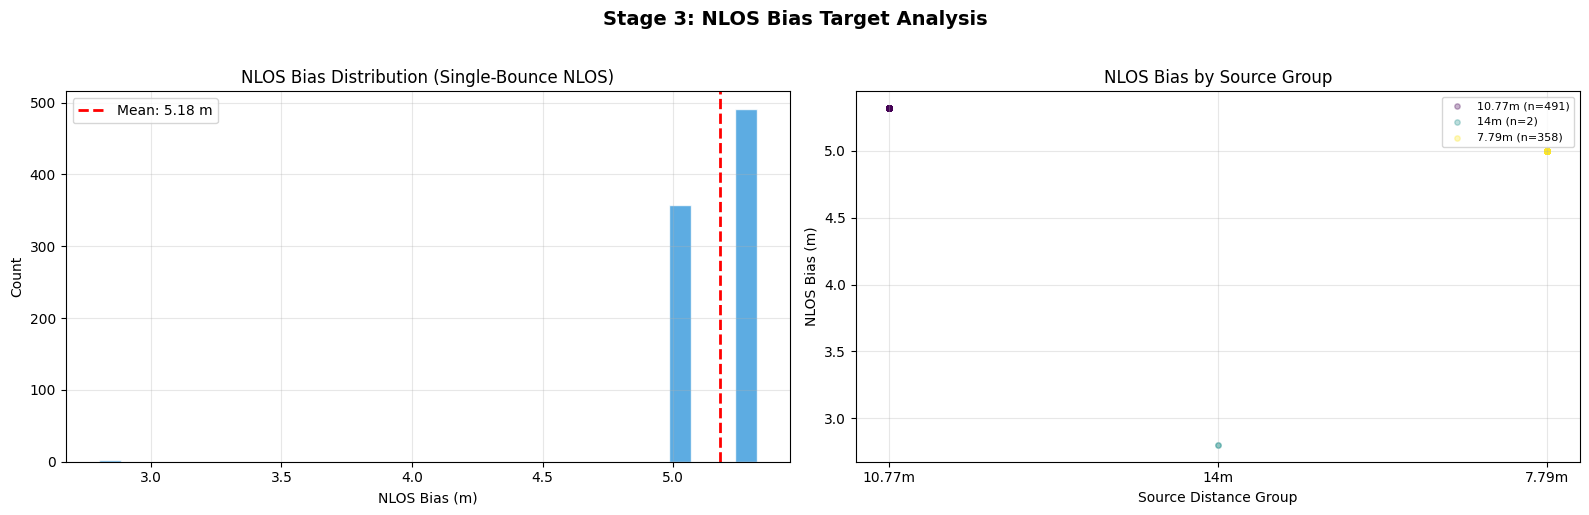


Per-Source-Group Statistics:
------------------------------------------------------------
Group           |    N |       Bias |   d_direct |   d_bounce
------------------------------------------------------------
10.77m          |  491 |       5.32 |      10.77 |      16.09
14m             |    2 |       2.80 |      14.00 |      16.80
7.79m           |  358 |       5.00 |       7.79 |      12.79


In [10]:
# ==========================================
# TARGET ANALYSIS
# ==========================================
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

# 1. NLOS bias distribution
ax = axs[0]
ax.hist(nlos_biases, bins=30, color='#3498db', edgecolor='white', alpha=0.8)
ax.axvline(nlos_biases.mean(), color='red', ls='--', lw=2,
           label=f'Mean: {nlos_biases.mean():.2f} m')
ax.set_xlabel("NLOS Bias (m)")
ax.set_ylabel("Count")
ax.set_title("NLOS Bias Distribution (Single-Bounce NLOS)")
ax.legend()
ax.grid(True, alpha=0.3)

# 2. Bias by source file group
ax = axs[1]
groups = [get_distance_group(s) for s in source_files]
unique_groups = sorted(set(groups))
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_groups)))

for i, grp in enumerate(unique_groups):
    mask = np.array([g == grp for g in groups])
    biases = nlos_biases[mask]
    ax.scatter(np.full(mask.sum(), i), biases, alpha=0.3, s=15,
               color=colors[i], label=f'{grp} (n={mask.sum()})')

ax.set_xticks(range(len(unique_groups)))
ax.set_xticklabels(unique_groups)
ax.set_xlabel("Source Distance Group")
ax.set_ylabel("NLOS Bias (m)")
ax.set_title("NLOS Bias by Source Group")
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

plt.suptitle("Stage 3: NLOS Bias Target Analysis",
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Per-group statistics
print("\nPer-Source-Group Statistics:")
print("-" * 60)
print(f"{'Group':<15} | {'N':>4} | {'Bias':>10} | {'d_direct':>10} | {'d_bounce':>10}")
print("-" * 60)
bounce_lookup = {"7.79m": (7.79, 12.79), "10.77m": (10.77, 16.09), "14m": (14.00, 16.80)}
for grp in unique_groups:
    mask = np.array([g == grp for g in groups])
    d_direct, d_bounce = bounce_lookup.get(grp, (0, 0))
    print(f"{grp:<15} | {mask.sum():>4} | {MEASURED_NLOS_BIAS[grp]:>10.2f} | "
          f"{d_direct:>10.2f} | {d_bounce:>10.2f}")

---
## Section 3a: Shared LNN Encoder — Embedding Extraction

Same frozen PI-HLNN encoder as Stage 2. We extract 48-dim mean-pooled hidden states as embeddings for each single-bounce NLOS sample. These embeddings serve as input to the Random Forest regressor for bias prediction.

Loaded Stage 1 PI-HLNN encoder (7,233 params, frozen)
Device: cuda
Embedding dimension: 48

Extracting LNN embeddings for 851 single-bounce samples...
Embeddings shape: (851, 48)
Embedding stats: mean=-0.0299, std=0.4475


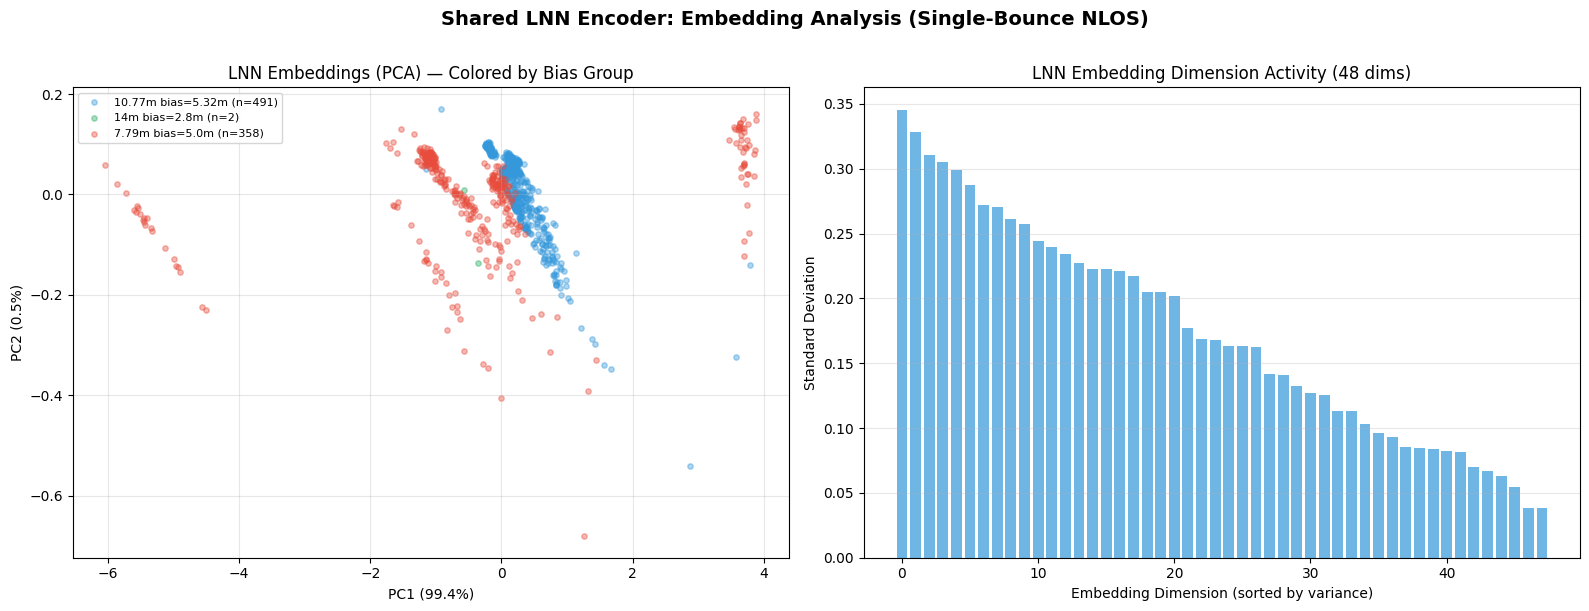

In [11]:
# ==========================================
# SHARED LNN ENCODER — Embedding Extraction
# ==========================================
# Same frozen PI-HLNN encoder as Stage 2. Extract 48-dim embeddings
# for single-bounce NLOS samples to use as input for bias prediction.
# ==========================================

import torch
import torch.nn as nn
import torch.nn.functional as F

# --- PI-HLNN Architecture (identical to Stage 1) ---
class PILiquidCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.synapse = nn.Linear(input_size + hidden_size, hidden_size)
        self.tau_net = nn.Sequential(
            nn.Linear(input_size + hidden_size, 32),
            nn.Tanh(),
            nn.Linear(32, hidden_size),
        )
        self.A = nn.Parameter(torch.ones(hidden_size) * -0.5)

    def forward(self, x_t, h_prev, dt=1.0):
        combined = torch.cat([x_t, h_prev], dim=1)
        tau = dt + F.softplus(self.tau_net(combined))
        S_t = torch.tanh(self.synapse(combined))
        numerator = h_prev + (dt * S_t * self.A)
        denominator = 1.0 + (dt / tau)
        return numerator / denominator, tau


class PI_HLNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=48, dropout=0.4):
        super().__init__()
        self.hidden_size = hidden_size
        self.cell = PILiquidCell(input_size, hidden_size)
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, 32), nn.SiLU(),
            nn.Dropout(dropout), nn.Linear(32, 1), nn.Sigmoid()
        )

    def forward(self, x_seq, return_dynamics=False):
        batch_size, seq_len, _ = x_seq.size()
        h_t = torch.zeros(batch_size, self.hidden_size, device=x_seq.device)
        h_sum = torch.zeros_like(h_t)
        tau_sum = torch.zeros_like(h_t)
        h_history, tau_history = [], []
        for t in range(seq_len):
            h_t, tau_t = self.cell(x_seq[:, t, :], h_t)
            h_sum += h_t
            tau_sum += tau_t
            if return_dynamics:
                h_history.append(h_t.unsqueeze(1))
                tau_history.append(tau_t.unsqueeze(1))
        h_pooled = h_sum / seq_len
        tau_mean = tau_sum / seq_len
        prediction = self.classifier(h_pooled)
        if return_dynamics:
            return prediction, torch.cat(h_history, dim=1), torch.cat(tau_history, dim=1), tau_mean
        return prediction, tau_mean


# --- Stage 1 CIR preprocessing (must match exactly) ---
STAGE1_CONFIG = {
    "pre_crop": 10, "post_crop": 50, "total_len": 60,
    "search_start": 740, "search_end": 890,
    "hidden_size": 48, "input_size": 1, "dropout": 0.4,
}

EMBEDDING_DIM = STAGE1_CONFIG["hidden_size"]
EMBEDDING_NAMES = [f"LNN_h{i}" for i in range(EMBEDDING_DIM)]


def preprocess_cir_for_lnn(sig, leading_edge):
    """Preprocess CIR exactly as Stage 1: crop around leading edge + instance normalize."""
    PRE = STAGE1_CONFIG["pre_crop"]
    TOTAL = STAGE1_CONFIG["total_len"]
    start = max(0, leading_edge - PRE)
    end = start + TOTAL
    if end > len(sig):
        end = len(sig)
        start = max(0, end - TOTAL)
    crop = sig[start:end]
    if len(crop) < TOTAL:
        crop = np.pad(crop, (0, TOTAL - len(crop)), mode='constant')
    local_min, local_max = np.min(crop), np.max(crop)
    rng = local_max - local_min
    return (crop - local_min) / rng if rng > 0 else np.zeros(TOTAL)


# --- Load frozen Stage 1 LNN encoder ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lnn_encoder = PI_HLNN(
    input_size=STAGE1_CONFIG["input_size"],
    hidden_size=STAGE1_CONFIG["hidden_size"],
    dropout=STAGE1_CONFIG["dropout"]
).to(device)
lnn_encoder.load_state_dict(torch.load("stage1_pi_hlnn_best.pt", map_location=device))
lnn_encoder.eval()

for param in lnn_encoder.parameters():
    param.requires_grad = False

total_params = sum(p.numel() for p in lnn_encoder.parameters())
print(f"Loaded Stage 1 PI-HLNN encoder ({total_params:,} params, frozen)")
print(f"Device: {device}")
print(f"Embedding dimension: {EMBEDDING_DIM}")

# --- Extract embeddings for single-bounce NLOS samples ---
print(f"\nExtracting LNN embeddings for {len(raw_sigs)} single-bounce samples...")

cir_sequences = []
for i in range(len(raw_sigs)):
    crop = preprocess_cir_for_lnn(raw_sigs[i], leading_edges[i])
    cir_sequences.append(crop)

cir_tensor = torch.tensor(
    np.array(cir_sequences).reshape(-1, STAGE1_CONFIG["total_len"], 1),
    dtype=torch.float32
).to(device)

# Extract in batches
BATCH_SIZE = 256
all_embeddings = []
with torch.no_grad():
    for i in range(0, len(cir_sequences), BATCH_SIZE):
        batch = cir_tensor[i:i+BATCH_SIZE]
        _, h_hist, _, _ = lnn_encoder(batch, return_dynamics=True)
        emb = h_hist.mean(dim=1).cpu().numpy()
        all_embeddings.append(emb)

embeddings = np.vstack(all_embeddings)

print(f"Embeddings shape: {embeddings.shape}")
print(f"Embedding stats: mean={embeddings.mean():.4f}, std={embeddings.std():.4f}")

# --- PCA visualization ---
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
emb_2d = pca.fit_transform(embeddings)

fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Colored by NLOS bias group
ax = axs[0]
groups = [get_distance_group(s) for s in source_files]
unique_groups = sorted(set(groups))
colors_map = {"7.79m": "#e74c3c", "10.77m": "#3498db", "14m": "#27ae60"}
for grp in unique_groups:
    mask = np.array([g == grp for g in groups])
    ax.scatter(emb_2d[mask, 0], emb_2d[mask, 1],
               alpha=0.4, s=15, color=colors_map.get(grp, 'gray'),
               label=f'{grp} bias={MEASURED_NLOS_BIAS[grp]}m (n={mask.sum()})')
ax.set_xlabel(f"PC1 ({100*pca.explained_variance_ratio_[0]:.1f}%)")
ax.set_ylabel(f"PC2 ({100*pca.explained_variance_ratio_[1]:.1f}%)")
ax.set_title("LNN Embeddings (PCA) — Colored by Bias Group")
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# Embedding dimension activity
ax = axs[1]
dim_vars = embeddings.std(axis=0)
sorted_dim_idx = np.argsort(dim_vars)[::-1]
ax.bar(range(len(dim_vars)), dim_vars[sorted_dim_idx], color='#3498db', alpha=0.7)
ax.set_xlabel("Embedding Dimension (sorted by variance)")
ax.set_ylabel("Standard Deviation")
ax.set_title(f"LNN Embedding Dimension Activity ({EMBEDDING_DIM} dims)")
ax.grid(True, alpha=0.3, axis='y')

plt.suptitle("Shared LNN Encoder: Embedding Analysis (Single-Bounce NLOS)",
             fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

---
## Section 5: Random Forest on LNN Embeddings

**Architecture**: Frozen PI-HLNN encoder → 48-dim embeddings → Random Forest Regressor

**Why this design:**
- **LNN encoder** (shared from Stage 1): Same encoder used in Stage 2. Processes raw CIR through ODE dynamics — frozen, no retraining.
- **Random Forest** (Stage 3 head): Handles 48-dim embeddings natively. Works well on small datasets (~851 single-bounce samples).
- **Multi-model**: The LNN encoder and RF regressor are **separate models** trained on different data.

**Parameters**: 200 trees, no max depth, min_samples_split=5, min_samples_leaf=2

In [12]:
# ==========================================
# RANDOM FOREST TRAINING ON LNN EMBEDDINGS (70/30 SPLIT)
# ==========================================
X_all = embeddings  # 48-dim LNN embeddings (from frozen Stage 1 PI-HLNN)
y_all = nlos_biases
sf_all = np.array(source_files)

# 70/30 split (also split source_files for group-level diagnostics)
X_train, X_test, y_train, y_test, sf_train, sf_test = train_test_split(
    X_all, y_all, sf_all,
    test_size=CONFIG["test_ratio"],
    random_state=CONFIG["seed"]
)

print(f"Input: {EMBEDDING_DIM}-dim LNN embeddings (from frozen Stage 1 PI-HLNN)")
print(f"\nSplit (70/30):")
print(f"  Train: {len(X_train)}")
print(f"  Test:  {len(X_test)}")

# Train Random Forest on LNN embeddings (no feature scaling needed)
rf_model = RandomForestRegressor(
    n_estimators=CONFIG["n_estimators"],
    max_depth=CONFIG["max_depth"],
    min_samples_split=CONFIG["min_samples_split"],
    min_samples_leaf=CONFIG["min_samples_leaf"],
    random_state=CONFIG["seed"],
    n_jobs=-1,
)
rf_model.fit(X_train, y_train)

# Evaluate
train_pred = rf_model.predict(X_train)
test_pred = rf_model.predict(X_test)

train_mae = mean_absolute_error(y_train, train_pred)
test_mae = mean_absolute_error(y_test, test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
test_r2 = r2_score(y_test, test_pred)

print(f"\nTrain MAE: {train_mae:.4f} m")
print(f"Test MAE:  {test_mae:.4f} m")
print(f"Test RMSE: {test_rmse:.4f} m")
print(f"Test R²:   {test_r2:.4f}")

Input: 48-dim LNN embeddings (from frozen Stage 1 PI-HLNN)

Split (70/30):
  Train: 595
  Test:  256

Train MAE: 0.0112 m
Test MAE:  0.0168 m
Test RMSE: 0.0750 m
Test R²:   0.7728


---
## Section 5: Random Forest Regressor

**Why Random Forest for regression:**
- Same reasoning as Stage 2 — small dataset (~846 single-bounce samples), tabular features
- RF handles regression natively with ensemble averaging
- No learning rate, epochs, or architecture to tune
- Built-in feature importance — shows which CIR timing features drive bias prediction
- Xu Xueli (2024) also used RF for her distance regression and achieved MAE=0.346m

**Parameters**: 200 trees, no max depth, min_samples_split=5, min_samples_leaf=2

C:\Users\preca\AppData\Local\Temp\ipykernel_15432\4161984564.py:52: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([grp_residuals[g] for g in unique_grps], labels=unique_grps)


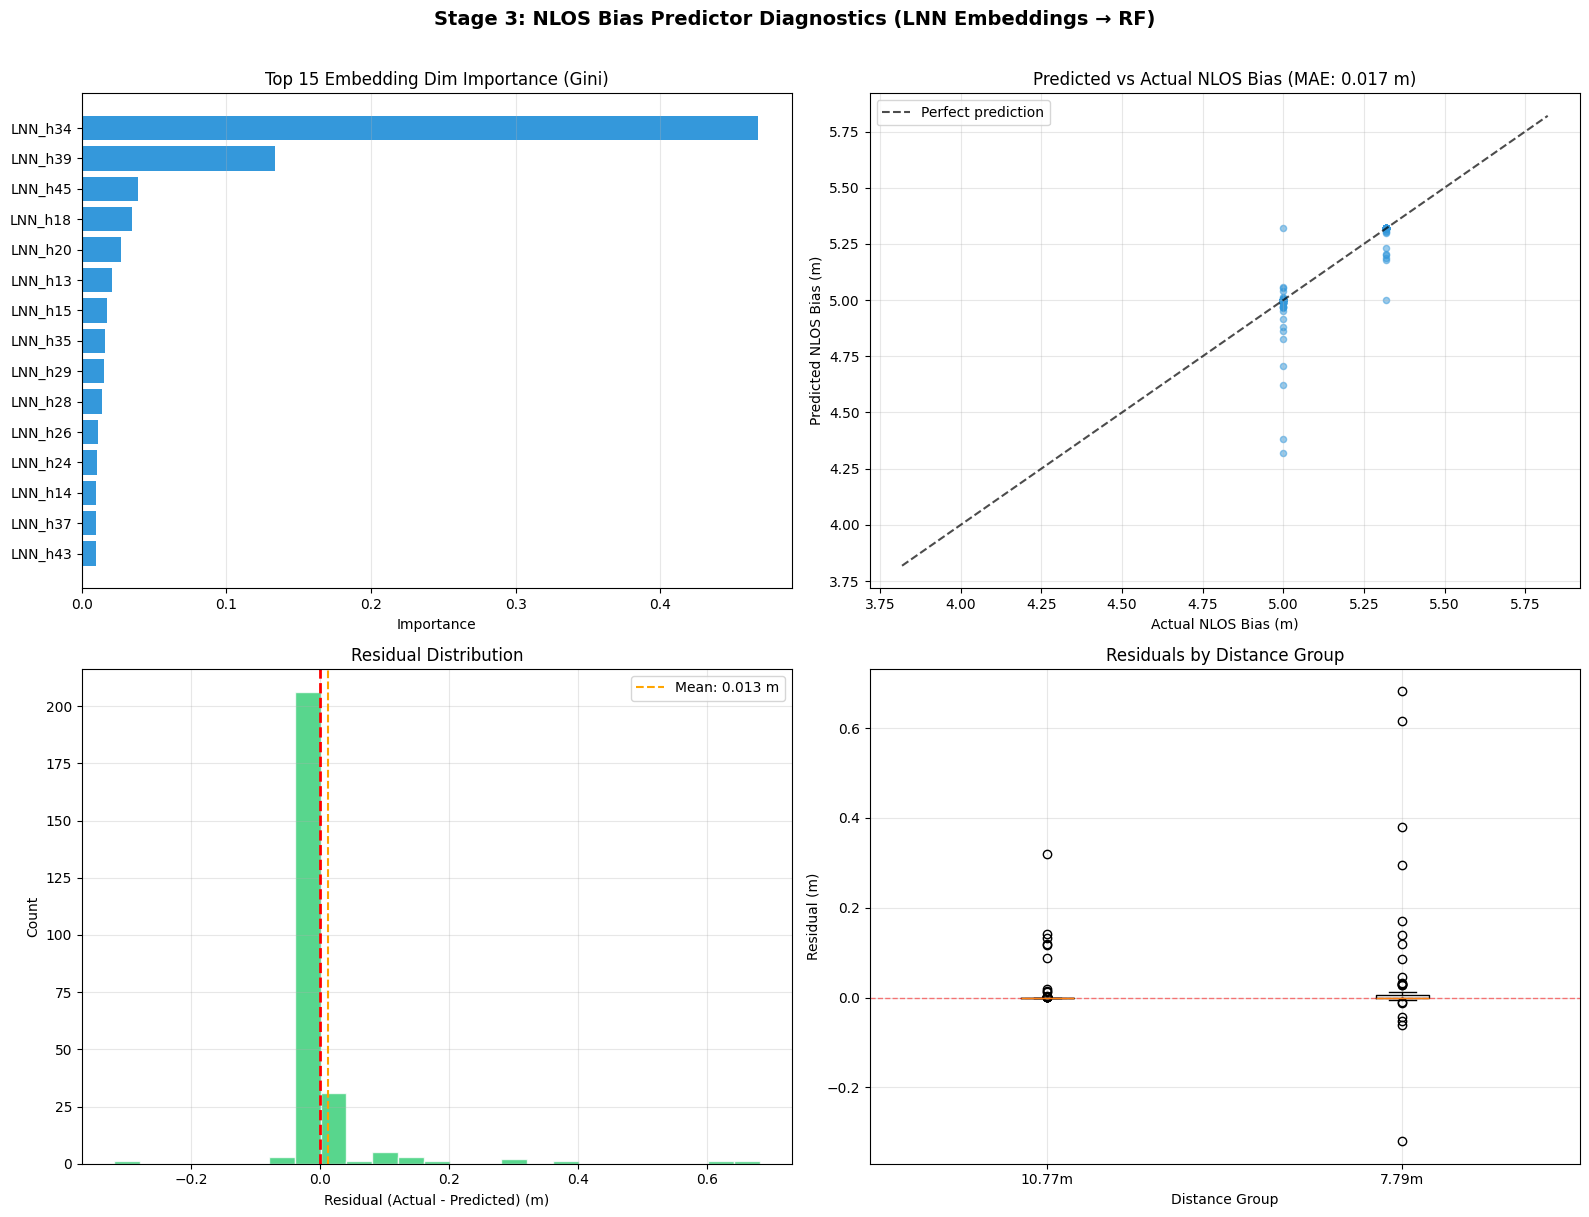


Validation Metrics:
  MAE:  0.0168 m
  RMSE: 0.0750 m
  R²:   0.7728
  Residual mean: 0.0128 m (bias)
  Residual std:  0.0739 m

Top 10 Embedding Dimension Importance (ranked):
  LNN_h34                   0.4677
  LNN_h39                   0.1339
  LNN_h45                   0.0389
  LNN_h18                   0.0348
  LNN_h20                   0.0270
  LNN_h13                   0.0209
  LNN_h15                   0.0172
  LNN_h35                   0.0163
  LNN_h29                   0.0157
  LNN_h28                   0.0139


In [13]:
# ==========================================
# DIAGNOSTICS
# ==========================================
y_pred_test = rf_model.predict(X_test)
residuals = y_test - y_pred_test

fig, axs = plt.subplots(2, 2, figsize=(16, 12))
plt.subplots_adjust(hspace=0.35, wspace=0.3)

# 1. Feature Importance (top 15 embedding dimensions)
ax = axs[0, 0]
importances = rf_model.feature_importances_
top_k = min(15, len(importances))
sorted_idx = np.argsort(importances)[-top_k:]
ax.barh(np.array(EMBEDDING_NAMES)[sorted_idx], importances[sorted_idx], color='#3498db')
ax.set_title(f"Top {top_k} Embedding Dim Importance (Gini)")
ax.set_xlabel("Importance")
ax.grid(True, alpha=0.3, axis='x')

# 2. Predicted vs Actual
ax = axs[0, 1]
ax.scatter(y_test, y_pred_test, alpha=0.5, s=20, color='#3498db')
lims = [min(y_test.min(), y_pred_test.min()) - 0.5,
        max(y_test.max(), y_pred_test.max()) + 0.5]
ax.plot(lims, lims, 'k--', lw=1.5, alpha=0.7, label='Perfect prediction')
mae = np.mean(np.abs(residuals))
ax.set_title(f"Predicted vs Actual NLOS Bias (MAE: {mae:.3f} m)")
ax.set_xlabel("Actual NLOS Bias (m)")
ax.set_ylabel("Predicted NLOS Bias (m)")
ax.legend()
ax.grid(True, alpha=0.3)

# 3. Residual Distribution
ax = axs[1, 0]
ax.hist(residuals, bins=25, color='#2ecc71', edgecolor='white', alpha=0.8)
ax.axvline(0, color='red', ls='--', lw=2)
ax.axvline(residuals.mean(), color='orange', ls='--', lw=1.5,
           label=f'Mean: {residuals.mean():.3f} m')
ax.set_title("Residual Distribution")
ax.set_xlabel("Residual (Actual - Predicted) (m)")
ax.set_ylabel("Count")
ax.legend()
ax.grid(True, alpha=0.3)

# 4. Residual by Group (using sf_test from split)
ax = axs[1, 1]
test_groups = [get_distance_group(sf) for sf in sf_test]
unique_grps = sorted(set(test_groups))
grp_residuals = {g: [] for g in unique_grps}
for g, r in zip(test_groups, residuals):
    grp_residuals[g].append(r)
ax.boxplot([grp_residuals[g] for g in unique_grps], labels=unique_grps)
ax.axhline(0, color='red', ls='--', lw=1, alpha=0.5)
ax.set_title("Residuals by Distance Group")
ax.set_xlabel("Distance Group")
ax.set_ylabel("Residual (m)")
ax.grid(True, alpha=0.3)

plt.suptitle("Stage 3: NLOS Bias Predictor Diagnostics (LNN Embeddings → RF)",
             fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

# Summary
print(f"\nValidation Metrics:")
print(f"  MAE:  {mae:.4f} m")
print(f"  RMSE: {np.sqrt(np.mean(residuals**2)):.4f} m")
print(f"  R²:   {test_r2:.4f}")
print(f"  Residual mean: {residuals.mean():.4f} m (bias)")
print(f"  Residual std:  {residuals.std():.4f} m")

print(f"\nTop 10 Embedding Dimension Importance (ranked):")
for feat, imp in sorted(zip(EMBEDDING_NAMES, importances), key=lambda x: -x[1])[:10]:
    print(f"  {feat:<25} {imp:.4f}")

---
## Section 6: Diagnostics

C:\Users\preca\AppData\Local\Temp\ipykernel_15432\4221282165.py:55: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([grp_residuals[g] for g in unique_grps], labels=unique_grps)


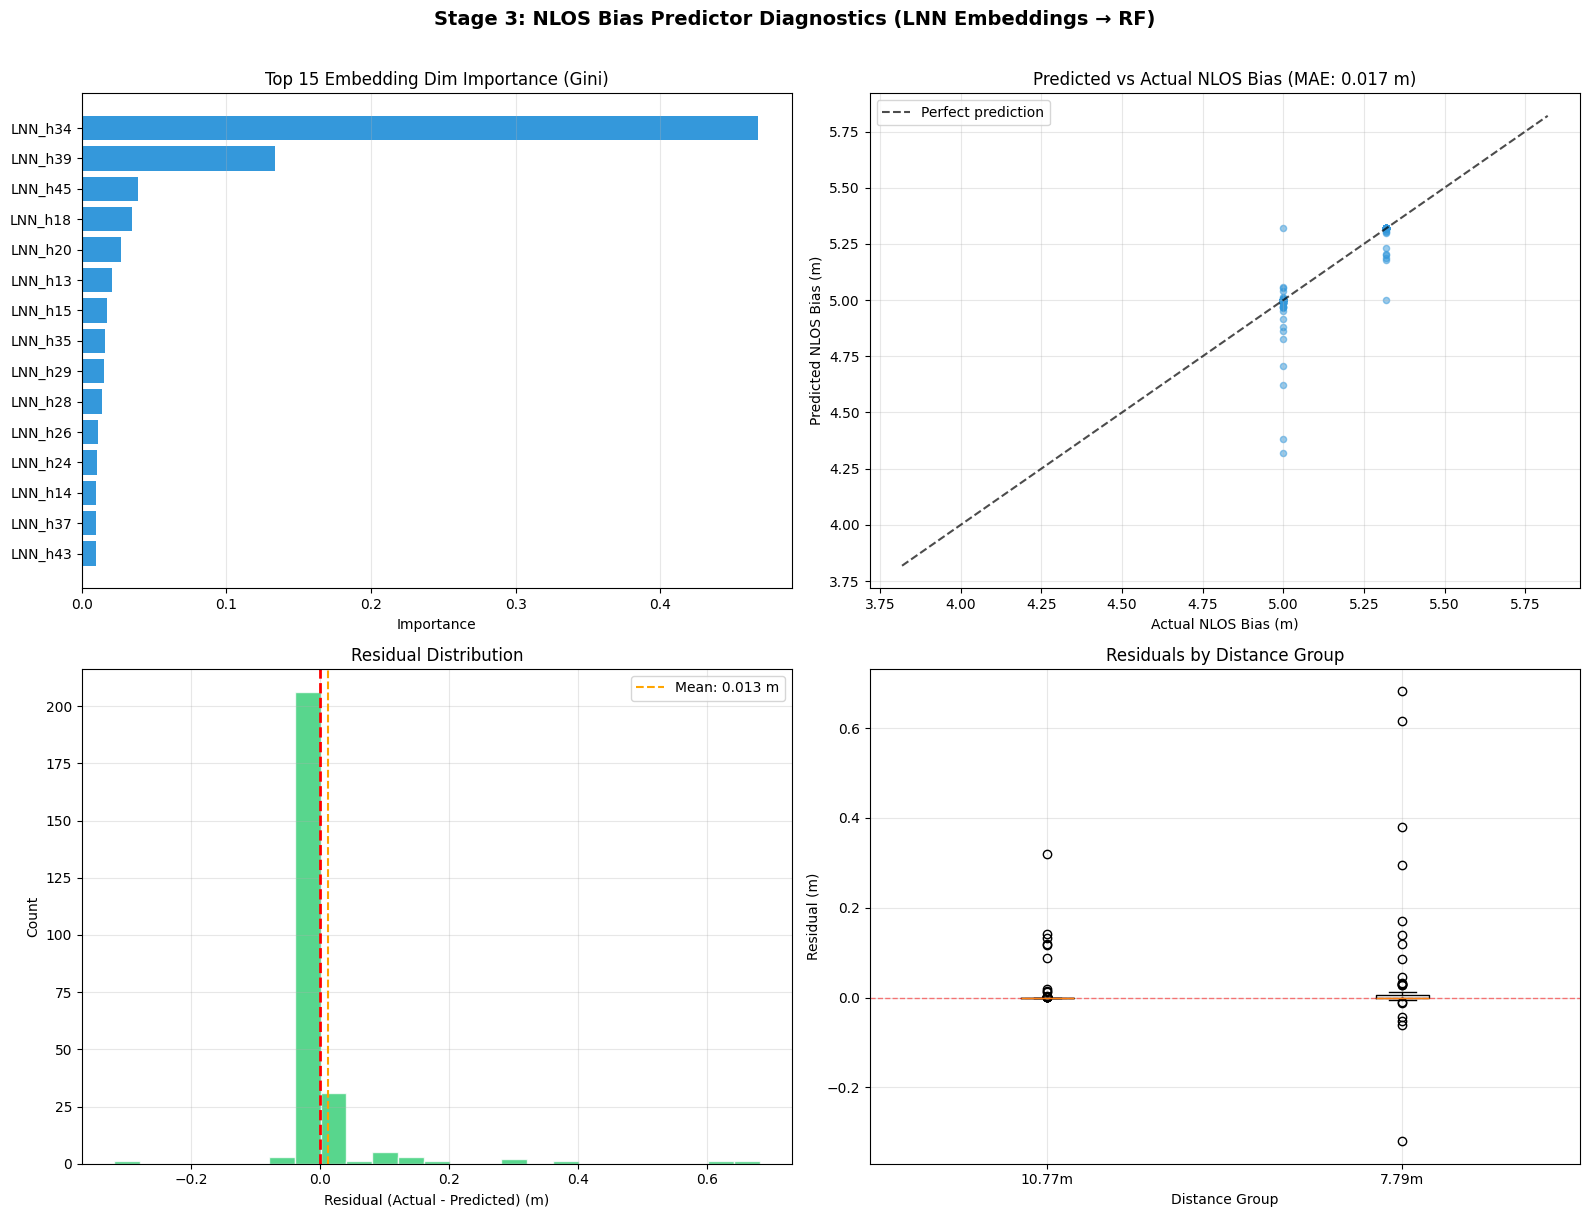


Validation Metrics:
  MAE:  0.0168 m
  RMSE: 0.0750 m
  R²:   0.7728
  Residual mean: 0.0128 m (bias)
  Residual std:  0.0739 m

Top 10 Embedding Dimension Importance (ranked):
  LNN_h34                   0.4677
  LNN_h39                   0.1339
  LNN_h45                   0.0389
  LNN_h18                   0.0348
  LNN_h20                   0.0270
  LNN_h13                   0.0209
  LNN_h15                   0.0172
  LNN_h35                   0.0163
  LNN_h29                   0.0157
  LNN_h28                   0.0139


In [14]:
# ==========================================
# DIAGNOSTICS (Legacy hand-crafted feature view)
# ==========================================
# This cell shows the same diagnostics but with hand-crafted feature names
# for interpretability. The RF model uses 48-dim LNN embeddings internally.

y_pred_test = rf_model.predict(X_test)
residuals = y_test - y_pred_test

fig, axs = plt.subplots(2, 2, figsize=(16, 12))
plt.subplots_adjust(hspace=0.35, wspace=0.3)

# 1. Feature Importance (top 15 embedding dimensions)
ax = axs[0, 0]
importances = rf_model.feature_importances_
top_k = min(15, len(importances))
sorted_idx = np.argsort(importances)[-top_k:]
ax.barh(np.array(EMBEDDING_NAMES)[sorted_idx], importances[sorted_idx], color='#3498db')
ax.set_title(f"Top {top_k} Embedding Dim Importance (Gini)")
ax.set_xlabel("Importance")
ax.grid(True, alpha=0.3, axis='x')

# 2. Predicted vs Actual
ax = axs[0, 1]
ax.scatter(y_test, y_pred_test, alpha=0.5, s=20, color='#3498db')
lims = [min(y_test.min(), y_pred_test.min()) - 0.5,
        max(y_test.max(), y_pred_test.max()) + 0.5]
ax.plot(lims, lims, 'k--', lw=1.5, alpha=0.7, label='Perfect prediction')
mae = np.mean(np.abs(residuals))
ax.set_title(f"Predicted vs Actual NLOS Bias (MAE: {mae:.3f} m)")
ax.set_xlabel("Actual NLOS Bias (m)")
ax.set_ylabel("Predicted NLOS Bias (m)")
ax.legend()
ax.grid(True, alpha=0.3)

# 3. Residual Distribution
ax = axs[1, 0]
ax.hist(residuals, bins=25, color='#2ecc71', edgecolor='white', alpha=0.8)
ax.axvline(0, color='red', ls='--', lw=2)
ax.axvline(residuals.mean(), color='orange', ls='--', lw=1.5,
           label=f'Mean: {residuals.mean():.3f} m')
ax.set_title("Residual Distribution")
ax.set_xlabel("Residual (Actual - Predicted) (m)")
ax.set_ylabel("Count")
ax.legend()
ax.grid(True, alpha=0.3)

# 4. Residual by Group (using sf_test from split)
ax = axs[1, 1]
test_groups = [get_distance_group(sf) for sf in sf_test]
unique_grps = sorted(set(test_groups))
grp_residuals = {g: [] for g in unique_grps}
for g, r in zip(test_groups, residuals):
    grp_residuals[g].append(r)
ax.boxplot([grp_residuals[g] for g in unique_grps], labels=unique_grps)
ax.axhline(0, color='red', ls='--', lw=1, alpha=0.5)
ax.set_title("Residuals by Distance Group")
ax.set_xlabel("Distance Group")
ax.set_ylabel("Residual (m)")
ax.grid(True, alpha=0.3)

plt.suptitle("Stage 3: NLOS Bias Predictor Diagnostics (LNN Embeddings → RF)",
             fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

# Summary
print(f"\nValidation Metrics:")
print(f"  MAE:  {mae:.4f} m")
print(f"  RMSE: {np.sqrt(np.mean(residuals**2)):.4f} m")
print(f"  R²:   {test_r2:.4f}")
print(f"  Residual mean: {residuals.mean():.4f} m (bias)")
print(f"  Residual std:  {residuals.std():.4f} m")

print(f"\nTop 10 Embedding Dimension Importance (ranked):")
for feat, imp in sorted(zip(EMBEDDING_NAMES, importances), key=lambda x: -x[1])[:10]:
    print(f"  {feat:<25} {imp:.4f}")

---
## Section 7: Diagnostics — ML vs Physics Comparison

---
## Section 7a: CIR Waveform — ML vs Physics-Based Justification

Visually compare Stage 3 ML predictions against physics-based TOA estimation
by showing representative CIR waveforms per group with both approaches side-by-side.

Stage 3: ML Bias Prediction → Distance Correction
Extracting LNN embeddings for 851 single-bounce samples...


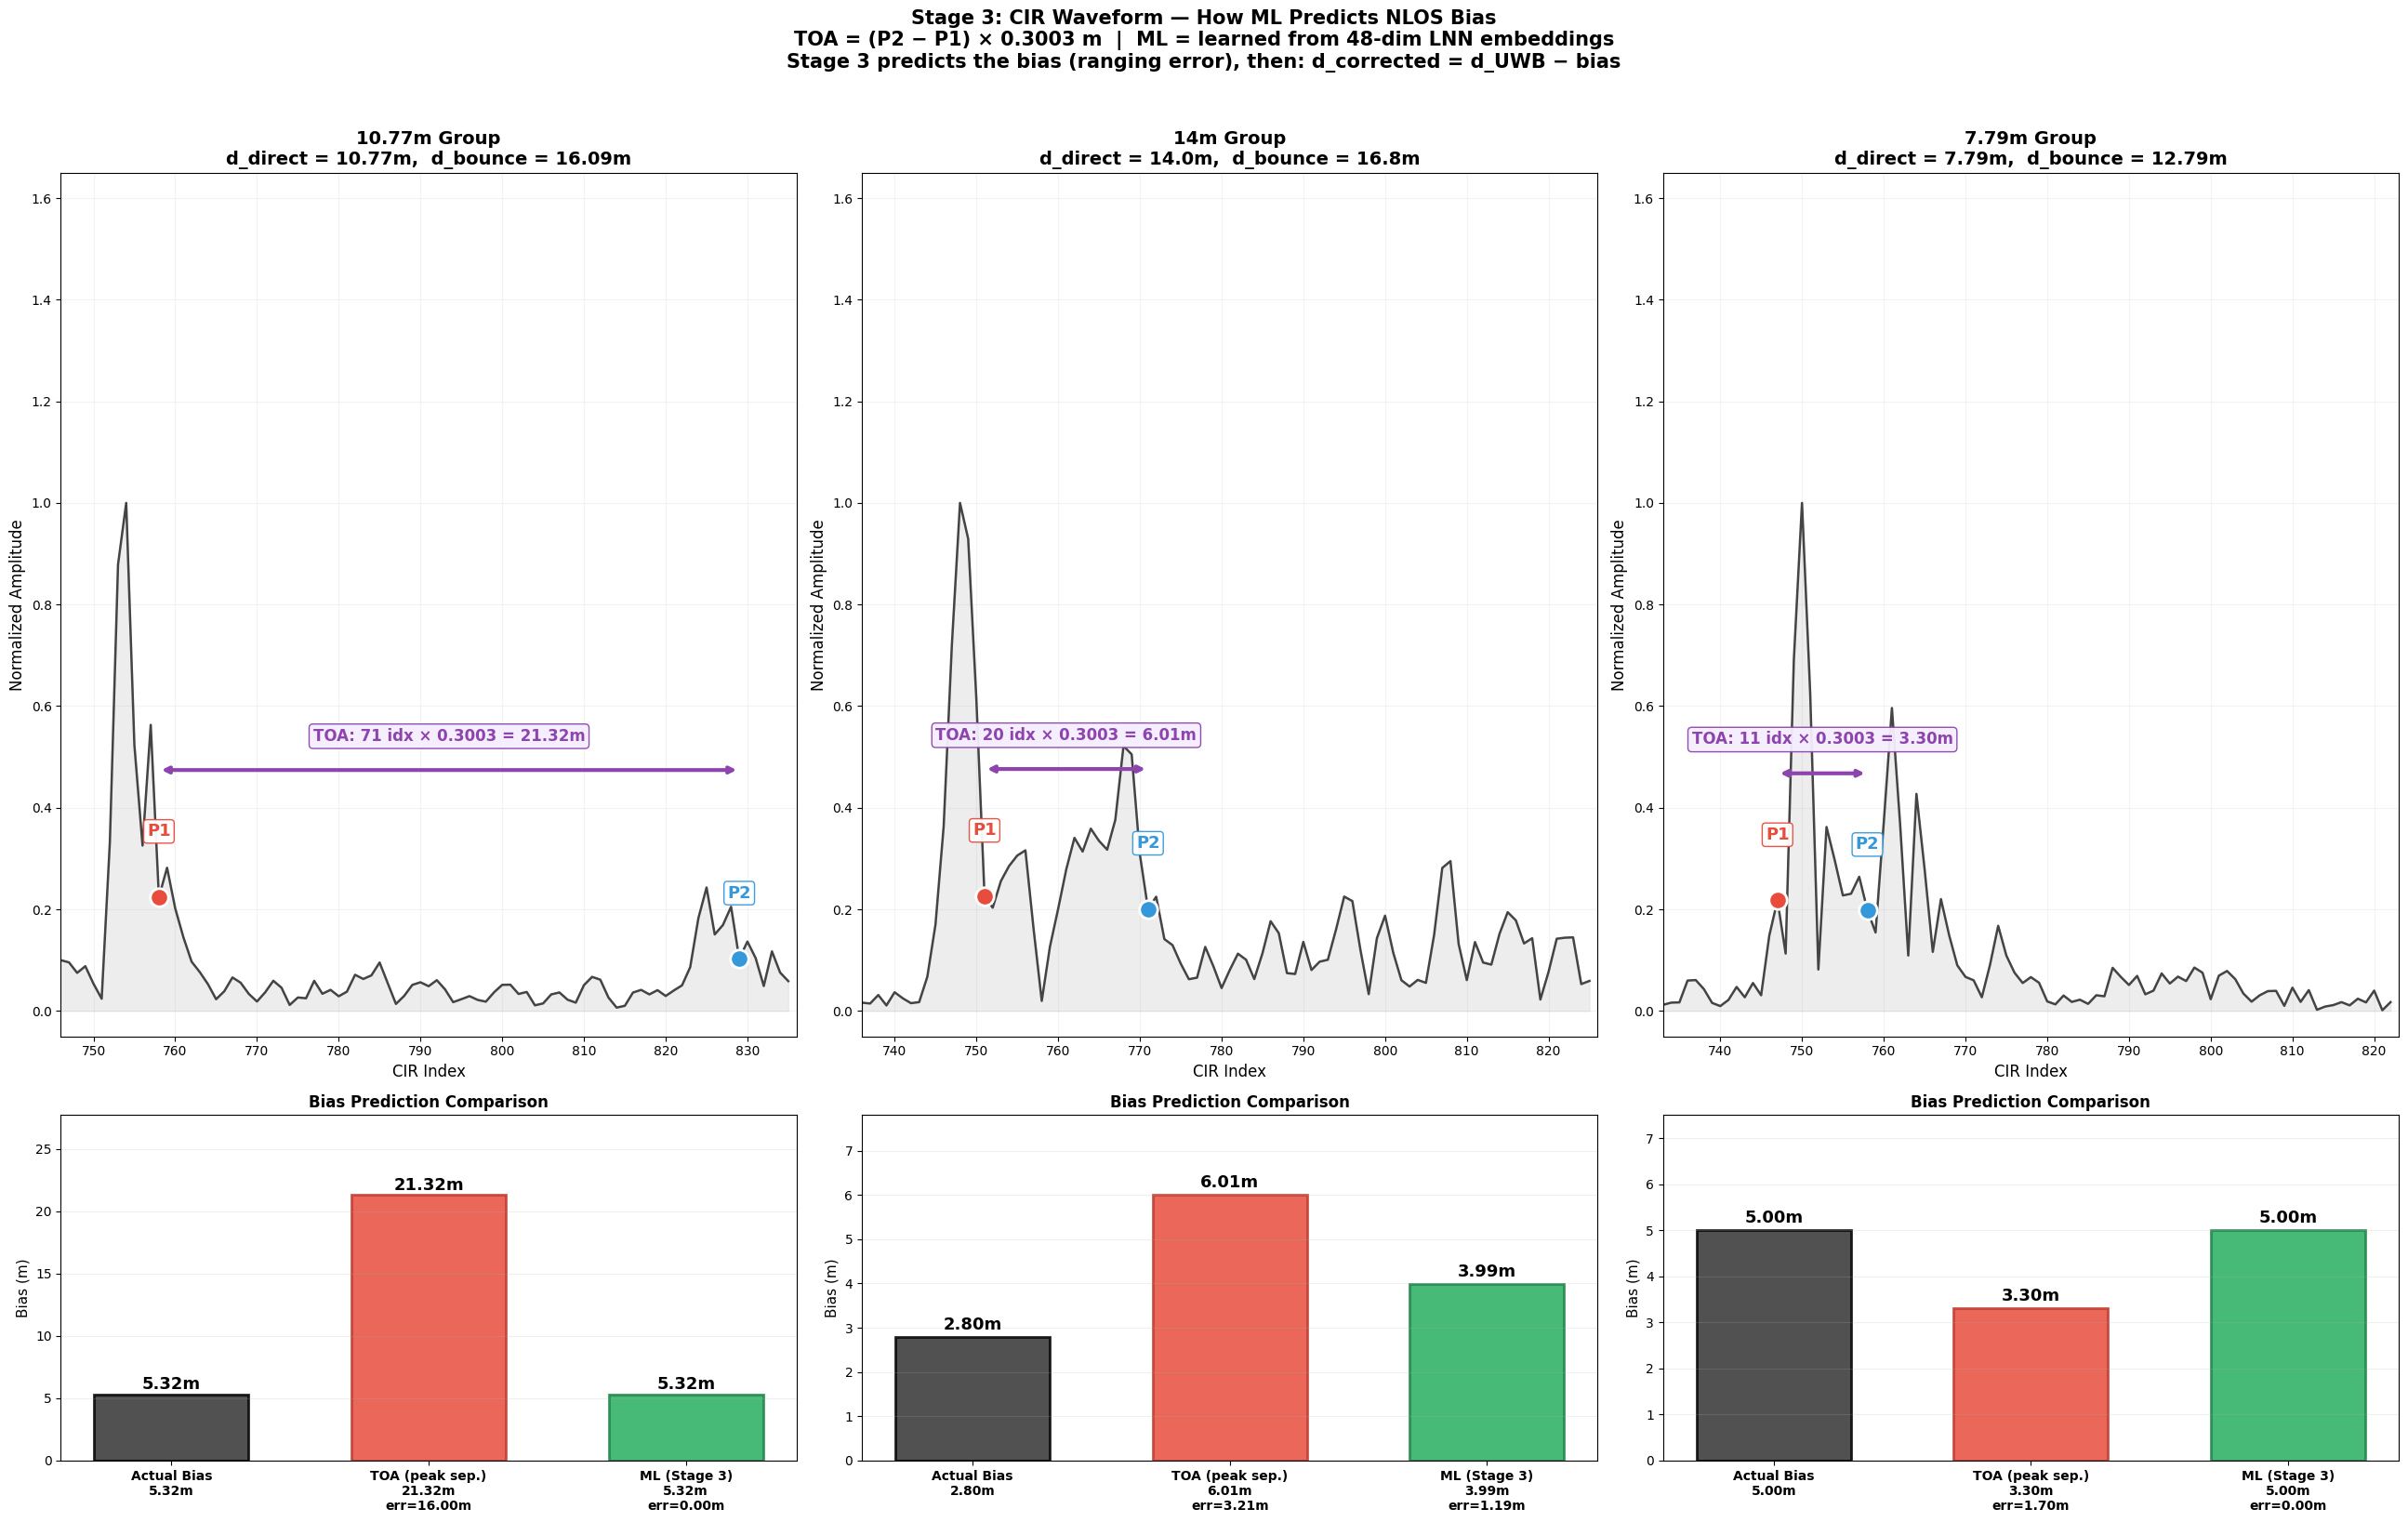

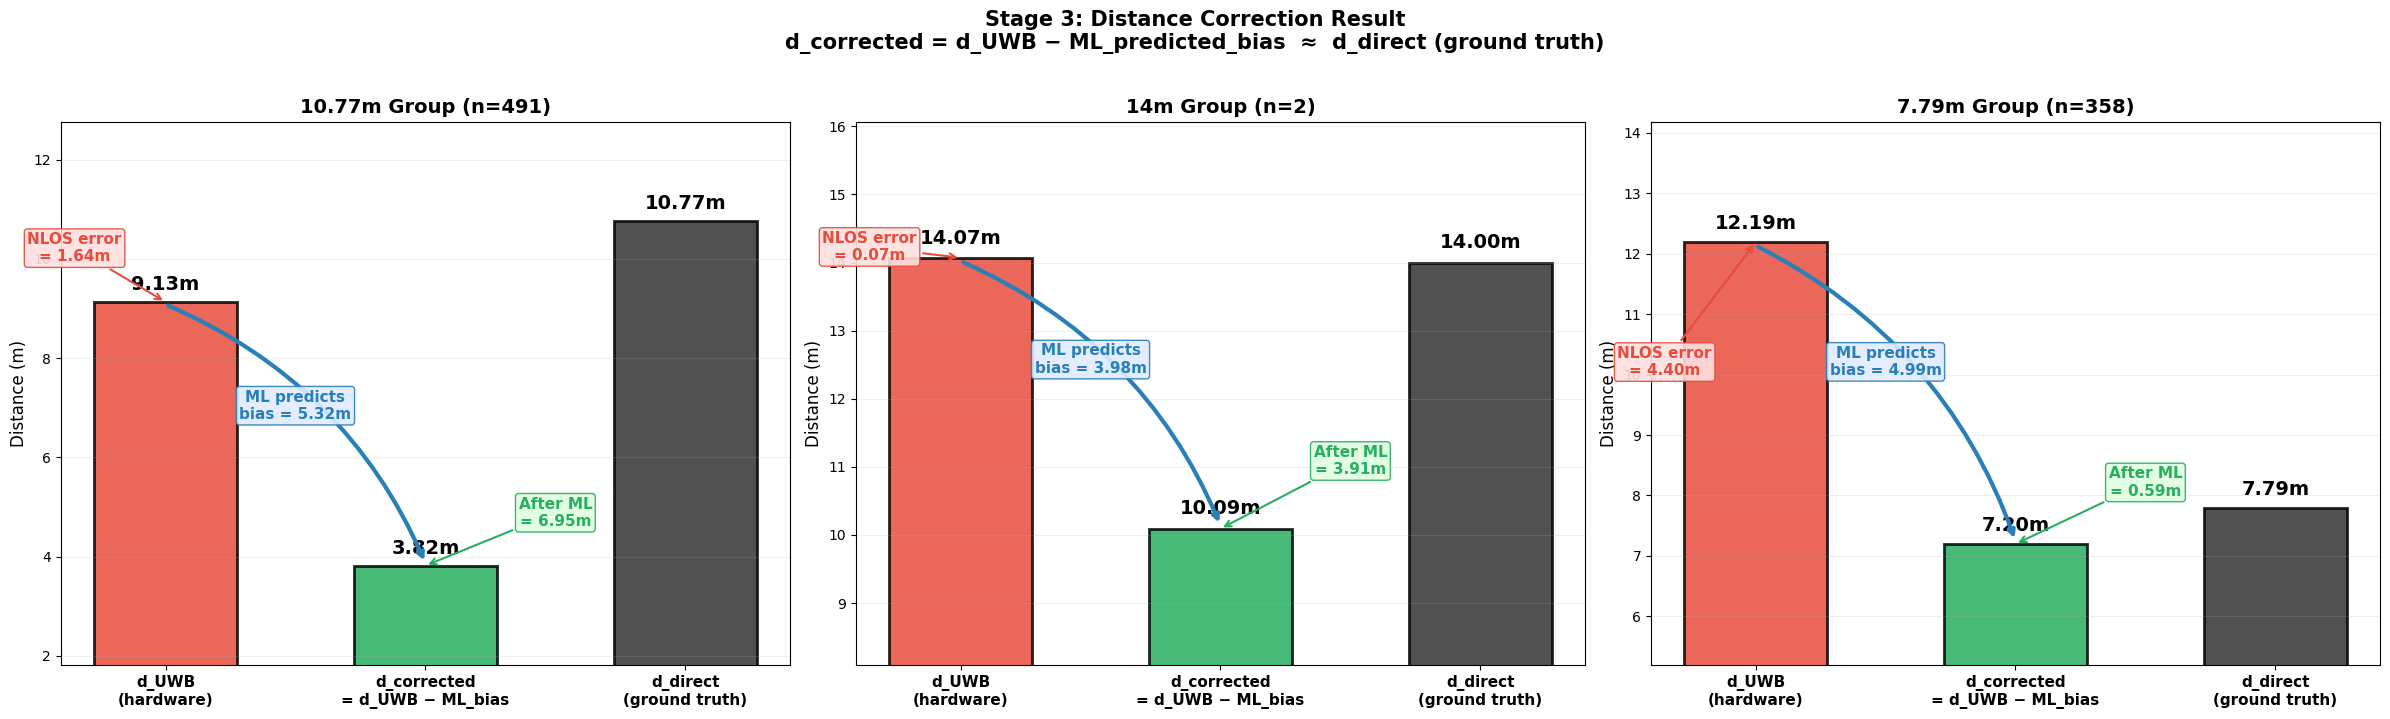

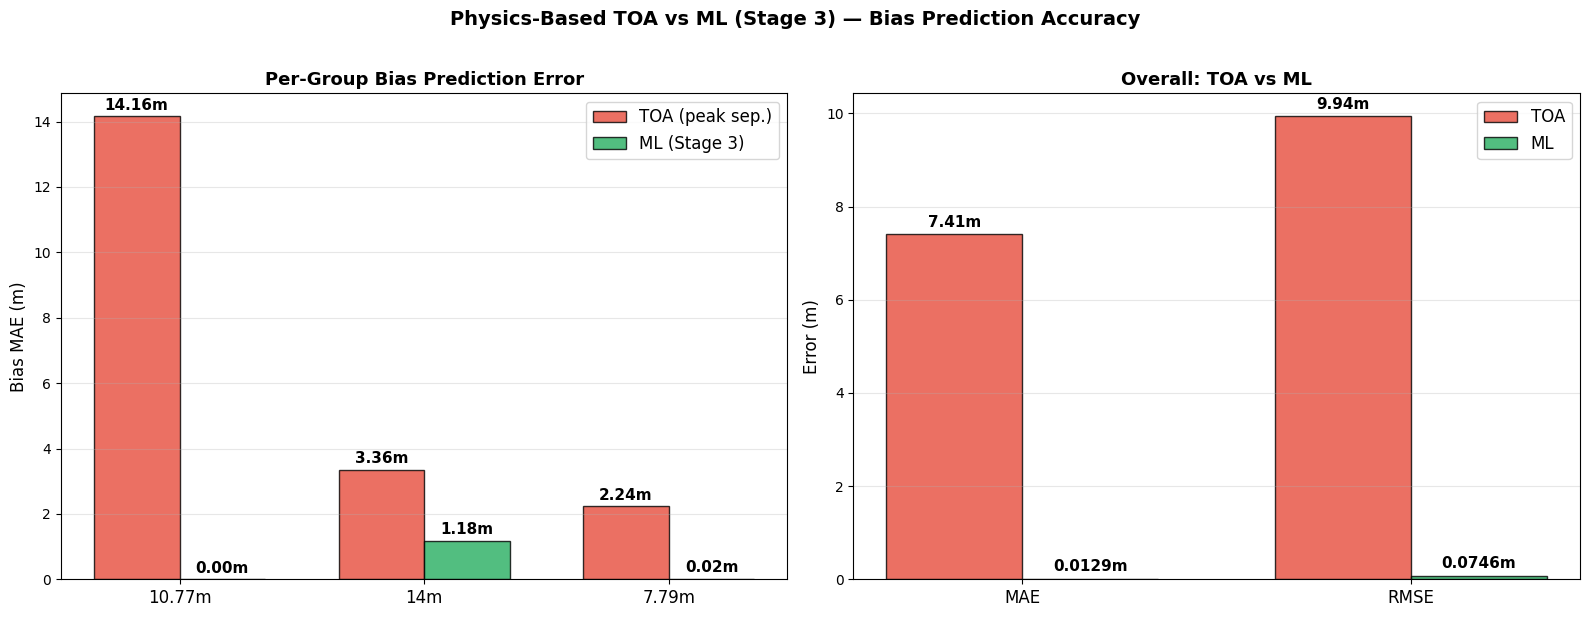


STAGE 3 RESULTS SUMMARY

  What Stage 3 predicts: NLOS BIAS (ranging error in meters)
  How to correct distance: d_corrected = d_UWB - predicted_bias
  Input: 48-dim LNN embeddings from frozen Stage 1 PI-HLNN

Method               |   Bias MAE |  Bias RMSE |  Samples
-------------------------------------------------------
TOA (peak sep.)      |     7.4063m |     9.9360m |      593
ML (Stage 3)         |     0.0129m |     0.0746m |      851

  ML improvement: 573.9x lower MAE

DISTANCE CORRECTION (d_corrected = d_UWB - ML_bias)
Group    |    d_UWB |  ML bias |  d_corrected |   d_direct |    Error |    N
----------------------------------------------------------------------
10.77m   |    9.13m |    5.32m |        3.82m |     10.77m |    6.95m |  491
14m      |   14.07m |    3.98m |       10.09m |     14.00m |    3.91m |    2
7.79m    |   12.19m |    4.99m |        7.20m |      7.79m |    0.59m |  358


In [15]:
# ==========================================
# CIR WAVEFORM — ML vs PHYSICS-BASED COMPARISON
# ==========================================
# Stage 3 predicts NLOS BIAS (the ranging error), NOT the bounce distance.
#
# Correction:  d_corrected = d_UWB - ML_predicted_bias ≈ d_direct
#
# Compare against physics-based TOA approach:
#   TOA:  bias = (P2_idx - P1_idx) × 0.3003 m   (peak separation)
#   ML:   bias = RandomForestRegressor(48-dim LNN embeddings)

CIR_SAMPLE_PERIOD_NS = 1.0016
SPEED_OF_LIGHT = 299_792_458
DIST_PER_INDEX = SPEED_OF_LIGHT * CIR_SAMPLE_PERIOD_NS * 1e-9  # ~0.3003 m

GROUND_TRUTH = {
    "7.79m":  {"d_direct": 7.79,  "d_bounce": 12.79, "bias": 5.00},
    "10.77m": {"d_direct": 10.77, "d_bounce": 16.09, "bias": 5.32},
    "14m":    {"d_direct": 14.00, "d_bounce": 16.80, "bias": 2.80},
}

# Re-load raw data for CIR access
df_raw = pd.read_csv("../dataset/channels/combined_uwb_dataset.csv")
nlos_raw_s3 = df_raw[df_raw["Label"] == 1].reset_index(drop=True)
cir_cols = sorted(
    [c for c in df_raw.columns if c.startswith('CIR')],
    key=lambda x: int(x.replace('CIR', ''))
)

print(f"Stage 3: ML Bias Prediction → Distance Correction")
print(f"{'='*60}")

# Process all single-bounce samples
# Collect CIR data for batch LNN embedding extraction
comparison_rows = []
comparison_sigs = []
comparison_les = []

for idx, row in nlos_raw_s3.iterrows():
    fname = str(row["Source_File"])
    group = get_distance_group(fname)
    if group not in MEASURED_NLOS_BIAS:
        continue

    uwb_dist = float(row["Distance"])
    sig = pd.to_numeric(row[cir_cols], errors='coerce').fillna(0).astype(float).values
    rxpacc = float(row.get('RXPACC', row.get('RX_PACC', 128.0)))
    if rxpacc > 0:
        sig = sig / rxpacc

    le = get_roi_alignment(sig)
    feats = extract_cir_features(sig, le)

    # Single-bounce filter (same as training)
    if feats["Num_Peaks"] > CONFIG["single_bounce_max_peaks"]:
        continue

    # TOA: relative peak separation
    roi_start = max(0, le - 5)
    roi_end = min(len(sig), le + 120)
    roi = sig[roi_start:roi_end]
    if len(roi) == 0 or np.max(roi) == 0:
        continue
    roi_norm = roi / np.max(roi)
    peaks, _ = find_peaks(
        roi_norm,
        prominence=CONFIG["peak_prominence"],
        distance=CONFIG["peak_min_distance"]
    )

    toa_bias = np.nan
    p1_abs, p2_abs = np.nan, np.nan
    if len(peaks) >= 2:
        p1_abs = roi_start + peaks[0]
        p2_abs = roi_start + peaks[1]
        toa_bias = (peaks[1] - peaks[0]) * DIST_PER_INDEX

    gt = GROUND_TRUTH[group]
    comparison_rows.append({
        "source_file": fname, "group": group,
        "leading_edge": le, "num_peaks": len(peaks),
        "peak1_abs": p1_abs, "peak2_abs": p2_abs,
        "toa_bias": toa_bias,
        "actual_bias": gt["bias"],
        "d_uwb": uwb_dist,
        "d_direct": gt["d_direct"],
    })
    comparison_sigs.append(sig)
    comparison_les.append(le)

# Batch extract LNN embeddings for all single-bounce samples
print(f"Extracting LNN embeddings for {len(comparison_sigs)} single-bounce samples...")
cir_sequences = []
for i in range(len(comparison_sigs)):
    crop = preprocess_cir_for_lnn(comparison_sigs[i], comparison_les[i])
    cir_sequences.append(crop)

cir_tensor = torch.tensor(
    np.array(cir_sequences).reshape(-1, STAGE1_CONFIG["total_len"], 1),
    dtype=torch.float32
).to(device)

all_embs = []
with torch.no_grad():
    for i in range(0, len(cir_sequences), 256):
        batch = cir_tensor[i:i+256]
        _, h_hist, _, _ = lnn_encoder(batch, return_dynamics=True)
        emb = h_hist.mean(dim=1).cpu().numpy()
        all_embs.append(emb)
comp_embeddings = np.vstack(all_embs)

# ML prediction using LNN embeddings
ml_biases = rf_model.predict(comp_embeddings)

# Build comparison DataFrame
comparison = []
for i, row_data in enumerate(comparison_rows):
    ml_b = ml_biases[i]
    row_data["ml_bias"] = ml_b
    row_data["d_corrected_ml"] = row_data["d_uwb"] - ml_b
    toa_b = row_data["toa_bias"]
    row_data["d_corrected_toa"] = row_data["d_uwb"] - toa_b if not np.isnan(toa_b) else np.nan
    comparison.append(row_data)

comp_df = pd.DataFrame(comparison)
comp_df["toa_error"] = (comp_df["toa_bias"] - comp_df["actual_bias"]).abs()
comp_df["ml_error"] = (comp_df["ml_bias"] - comp_df["actual_bias"]).abs()

# ============================================================
# FIGURE 1: CIR WAVEFORMS — Clear ML vs TOA annotation
# ============================================================
fig, axs = plt.subplots(2, 3, figsize=(26, 16),
                        gridspec_kw={"height_ratios": [3, 1.2]})

for i, grp in enumerate(sorted(GROUND_TRUTH.keys())):
    ax_cir = axs[0, i]   # top row: CIR waveform
    ax_bar = axs[1, i]   # bottom row: bias comparison bars
    gt = GROUND_TRUTH[grp]
    grp_sub = comp_df[comp_df["group"] == grp]

    if len(grp_sub) == 0:
        ax_cir.text(0.5, 0.5, f"No data for {grp}", transform=ax_cir.transAxes,
                    ha='center', fontsize=14)
        continue

    # Pick sample with TOA data, closest to median ML prediction
    toa_valid_sub = grp_sub.dropna(subset=["toa_bias"])
    pick_pool = toa_valid_sub if len(toa_valid_sub) > 0 else grp_sub
    sorted_pool = pick_pool.sort_values("ml_bias")
    pick = sorted_pool.iloc[len(sorted_pool) // 2]

    # Load CIR
    match = nlos_raw_s3[nlos_raw_s3["Source_File"] == pick["source_file"]]
    if len(match) == 0:
        continue
    row_data = match.iloc[0]
    sig = pd.to_numeric(row_data[cir_cols], errors='coerce').fillna(0).astype(float).values
    rxpacc = float(row_data.get('RXPACC', row_data.get('RX_PACC', 128.0)))
    if rxpacc > 0:
        sig = sig / rxpacc

    le = int(pick["leading_edge"])
    plot_start = max(0, le - 10)
    plot_end = min(len(sig), le + 80)
    x_idx = np.arange(plot_start, plot_end)
    y_vals = sig[plot_start:plot_end]
    y_max = np.max(y_vals) if np.max(y_vals) > 0 else 1
    y_norm = y_vals / y_max

    # --- TOP ROW: CIR waveform ---
    ax_cir.plot(x_idx, y_norm, color='#444', lw=1.8)
    ax_cir.fill_between(x_idx, 0, y_norm, color='#ddd', alpha=0.5)

    # Peaks
    p1 = pick["peak1_abs"]
    p2 = pick["peak2_abs"]
    has_toa = not np.isnan(p1) and not np.isnan(p2)

    if has_toa:
        p1, p2 = int(p1), int(p2)
        sep_idx = p2 - p1

        # P1 marker + label
        if plot_start <= p1 <= plot_end:
            p1_y = sig[p1] / y_max
            ax_cir.plot(p1, p1_y, 'o', color='#e74c3c', markersize=14, zorder=10,
                        markeredgecolor='white', markeredgewidth=2)
            ax_cir.annotate(
                f'P1', xy=(p1, p1_y), xytext=(p1, p1_y + 0.12),
                fontsize=13, fontweight='bold', color='#e74c3c', ha='center',
                bbox=dict(facecolor='white', edgecolor='#e74c3c',
                          boxstyle='round,pad=0.2', alpha=0.95))

        # P2 marker + label
        if plot_start <= p2 <= plot_end:
            p2_y = sig[p2] / y_max
            ax_cir.plot(p2, p2_y, 'o', color='#3498db', markersize=14, zorder=10,
                        markeredgecolor='white', markeredgewidth=2)
            ax_cir.annotate(
                f'P2', xy=(p2, p2_y), xytext=(p2, p2_y + 0.12),
                fontsize=13, fontweight='bold', color='#3498db', ha='center',
                bbox=dict(facecolor='white', edgecolor='#3498db',
                          boxstyle='round,pad=0.2', alpha=0.95))

        # Separation bracket
        bracket_y = max(sig[p1]/y_max, sig[p2]/y_max) + 0.25
        ax_cir.annotate('', xy=(p2, bracket_y), xytext=(p1, bracket_y),
                        arrowprops=dict(arrowstyle='<->', color='#8e44ad', lw=3))
        ax_cir.text((p1 + p2) / 2, bracket_y + 0.05,
                    f'TOA: {sep_idx} idx \u00d7 0.3003 = {pick["toa_bias"]:.2f}m',
                    ha='center', va='bottom', fontsize=12, fontweight='bold',
                    color='#8e44ad',
                    bbox=dict(facecolor='#f5eeff', edgecolor='#8e44ad',
                              boxstyle='round,pad=0.25', alpha=0.95))

    ax_cir.set_xlim(plot_start, plot_end)
    ax_cir.set_ylim(-0.05, 1.65)
    ax_cir.set_xlabel("CIR Index", fontsize=12)
    ax_cir.set_ylabel("Normalized Amplitude", fontsize=12)
    ax_cir.set_title(f'{grp} Group\nd_direct = {gt["d_direct"]}m,  d_bounce = {gt["d_bounce"]}m',
                     fontsize=14, fontweight='bold')
    ax_cir.grid(True, alpha=0.15)

    # --- BOTTOM ROW: Bias comparison bars ---
    actual = pick["actual_bias"]
    ml_b = pick["ml_bias"]
    toa_b = pick["toa_bias"] if has_toa else 0

    labels = []
    values = []
    colors = []
    edge_colors = []

    # Actual bias (ground truth)
    labels.append(f'Actual Bias\n{actual:.2f}m')
    values.append(actual)
    colors.append('#333333')
    edge_colors.append('black')

    # TOA estimate
    if has_toa:
        toa_err = abs(toa_b - actual)
        labels.append(f'TOA (peak sep.)\n{toa_b:.2f}m\nerr={toa_err:.2f}m')
        values.append(toa_b)
        colors.append('#e74c3c')
        edge_colors.append('#c0392b')

    # ML estimate
    ml_err = abs(ml_b - actual)
    labels.append(f'ML (Stage 3)\n{ml_b:.2f}m\nerr={ml_err:.2f}m')
    values.append(ml_b)
    colors.append('#27ae60')
    edge_colors.append('#1e8449')

    x_pos = np.arange(len(labels))
    bars = ax_bar.bar(x_pos, values, color=colors, edgecolor=edge_colors,
                      linewidth=2, alpha=0.85, width=0.6)

    # Value labels on bars
    for bar, val in zip(bars, values):
        ax_bar.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.08,
                    f'{val:.2f}m', ha='center', va='bottom',
                    fontsize=13, fontweight='bold')

    ax_bar.set_xticks(x_pos)
    ax_bar.set_xticklabels(labels, fontsize=10, fontweight='bold')
    ax_bar.set_ylabel("Bias (m)", fontsize=11)
    ax_bar.set_title("Bias Prediction Comparison", fontsize=12, fontweight='bold')
    ax_bar.grid(True, alpha=0.2, axis='y')
    y_top = max(values) * 1.3 if max(values) > 0 else 5
    ax_bar.set_ylim(0, max(y_top, actual * 1.5))

fig.suptitle(
    "Stage 3: CIR Waveform \u2014 How ML Predicts NLOS Bias\n"
    "TOA = (P2 \u2212 P1) \u00d7 0.3003 m  |  ML = learned from 48-dim LNN embeddings\n"
    "Stage 3 predicts the bias (ranging error), then: d_corrected = d_UWB \u2212 bias",
    fontsize=15, fontweight='bold', y=1.02
)
plt.tight_layout()
plt.show()

# ============================================================
# FIGURE 2: DISTANCE CORRECTION DEMONSTRATION
# ============================================================
# This is the practical result: d_corrected = d_UWB - ML_bias ≈ d_direct
fig, axs = plt.subplots(1, 3, figsize=(24, 7))

for i, grp in enumerate(sorted(GROUND_TRUTH.keys())):
    ax = axs[i]
    gt = GROUND_TRUTH[grp]
    grp_sub = comp_df[comp_df["group"] == grp]

    if len(grp_sub) == 0:
        continue

    d_uwb_mean = grp_sub["d_uwb"].mean()
    ml_bias_mean = grp_sub["ml_bias"].mean()
    d_corrected_mean = grp_sub["d_corrected_ml"].mean()
    d_direct = gt["d_direct"]

    # 3 bars: d_UWB (biased), d_corrected (ML), d_direct (truth)
    labels = [
        f'd_UWB\n(hardware)',
        f'd_corrected\n= d_UWB \u2212 ML_bias',
        f'd_direct\n(ground truth)'
    ]
    vals = [d_uwb_mean, d_corrected_mean, d_direct]
    bar_colors = ['#e74c3c', '#27ae60', '#333333']

    bars = ax.bar(range(3), vals, color=bar_colors, edgecolor='black',
                  linewidth=2, alpha=0.85, width=0.55)

    # Value + error labels
    for j, (bar, val) in enumerate(zip(bars, vals)):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.15,
                f'{val:.2f}m', ha='center', va='bottom',
                fontsize=14, fontweight='bold')

    # Error annotations
    # d_UWB error
    uwb_err = abs(d_uwb_mean - d_direct)
    ax.annotate(
        f'NLOS error\n= {uwb_err:.2f}m',
        xy=(0, d_uwb_mean), xytext=(-0.35, (d_uwb_mean + d_direct)/2),
        fontsize=11, fontweight='bold', color='#e74c3c', ha='center',
        arrowprops=dict(arrowstyle='->', color='#e74c3c', lw=1.5),
        bbox=dict(facecolor='#ffe0e0', edgecolor='#e74c3c',
                  boxstyle='round,pad=0.2', alpha=0.9))

    # Corrected error
    corr_err = abs(d_corrected_mean - d_direct)
    ax.annotate(
        f'After ML\n= {corr_err:.2f}m',
        xy=(1, d_corrected_mean), xytext=(1.5, d_corrected_mean + 0.8),
        fontsize=11, fontweight='bold', color='#27ae60', ha='center',
        arrowprops=dict(arrowstyle='->', color='#27ae60', lw=1.5),
        bbox=dict(facecolor='#e0ffe0', edgecolor='#27ae60',
                  boxstyle='round,pad=0.2', alpha=0.9))

    # Arrow showing correction
    mid_y = (d_uwb_mean + d_corrected_mean) / 2
    ax.annotate('', xy=(1, d_corrected_mean + 0.05), xytext=(0, d_uwb_mean - 0.05),
                arrowprops=dict(arrowstyle='->', color='#2980b9', lw=3,
                                connectionstyle='arc3,rad=-0.2'))
    ax.text(0.5, mid_y + 0.3,
            f'ML predicts\nbias = {ml_bias_mean:.2f}m',
            ha='center', fontsize=11, fontweight='bold', color='#2980b9',
            bbox=dict(facecolor='#e0ecff', edgecolor='#2980b9',
                      boxstyle='round,pad=0.2', alpha=0.9))

    ax.set_xticks(range(3))
    ax.set_xticklabels(labels, fontsize=11, fontweight='bold')
    ax.set_ylabel("Distance (m)", fontsize=12)
    ax.set_title(f'{grp} Group (n={len(grp_sub)})', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.2, axis='y')

    # y-axis range
    y_min = min(vals) - 2
    y_max_val = max(vals) + 2
    ax.set_ylim(max(0, y_min), y_max_val)

fig.suptitle(
    "Stage 3: Distance Correction Result\n"
    "d_corrected = d_UWB \u2212 ML_predicted_bias  \u2248  d_direct (ground truth)",
    fontsize=15, fontweight='bold', y=1.02
)
plt.tight_layout()
plt.show()

# ============================================================
# FIGURE 3: TOA vs ML bar chart
# ============================================================
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# 3a. MAE per group
ax = axs[0]
groups = sorted(GROUND_TRUTH.keys())
x_pos = np.arange(len(groups))
width = 0.35

toa_maes, ml_maes = [], []
for grp in groups:
    mask = comp_df["group"] == grp
    toa_m = comp_df.loc[mask & comp_df["toa_error"].notna(), "toa_error"]
    toa_maes.append(toa_m.mean() if len(toa_m) > 0 else 0)
    ml_maes.append(comp_df.loc[mask, "ml_error"].mean())

bars_toa = ax.bar(x_pos - width/2, toa_maes, width, label='TOA (peak sep.)',
                  color='#e74c3c', alpha=0.8, edgecolor='black')
bars_ml = ax.bar(x_pos + width/2, ml_maes, width, label='ML (Stage 3)',
                 color='#27ae60', alpha=0.8, edgecolor='black')
for bar, val in zip(bars_toa, toa_maes):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
            f'{val:.2f}m', ha='center', va='bottom', fontsize=11, fontweight='bold')
for bar, val in zip(bars_ml, ml_maes):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
            f'{val:.2f}m', ha='center', va='bottom', fontsize=11, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(groups, fontsize=12)
ax.set_ylabel("Bias MAE (m)", fontsize=12)
ax.set_title("Per-Group Bias Prediction Error", fontsize=13, fontweight='bold')
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3, axis='y')

# 3b. Overall
ax = axs[1]
toa_valid = comp_df.dropna(subset=["toa_bias"])
o_toa_mae = toa_valid["toa_error"].mean() if len(toa_valid) > 0 else 0
o_toa_rmse = np.sqrt((toa_valid["toa_error"]**2).mean()) if len(toa_valid) > 0 else 0
o_ml_mae = comp_df["ml_error"].mean()
o_ml_rmse = np.sqrt((comp_df["ml_error"]**2).mean())

metrics = ['MAE', 'RMSE']
x_pos2 = np.arange(len(metrics))
ax.bar(x_pos2 - width/2, [o_toa_mae, o_toa_rmse], width,
       label='TOA', color='#e74c3c', alpha=0.8, edgecolor='black')
bars_m = ax.bar(x_pos2 + width/2, [o_ml_mae, o_ml_rmse], width,
                label='ML', color='#27ae60', alpha=0.8, edgecolor='black')
for bar, val in zip(ax.containers[0], [o_toa_mae, o_toa_rmse]):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
            f'{val:.2f}m', ha='center', va='bottom', fontsize=11, fontweight='bold')
for bar, val in zip(bars_m, [o_ml_mae, o_ml_rmse]):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
            f'{val:.4f}m', ha='center', va='bottom', fontsize=11, fontweight='bold')
ax.set_xticks(x_pos2)
ax.set_xticklabels(metrics, fontsize=12)
ax.set_ylabel("Error (m)", fontsize=12)
ax.set_title("Overall: TOA vs ML", fontsize=13, fontweight='bold')
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3, axis='y')

plt.suptitle("Physics-Based TOA vs ML (Stage 3) \u2014 Bias Prediction Accuracy",
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# ============================================================
# Summary
# ============================================================
print(f"\n{'='*70}")
print(f"STAGE 3 RESULTS SUMMARY")
print(f"{'='*70}")
print(f"\n  What Stage 3 predicts: NLOS BIAS (ranging error in meters)")
print(f"  How to correct distance: d_corrected = d_UWB - predicted_bias")
print(f"  Input: 48-dim LNN embeddings from frozen Stage 1 PI-HLNN")
print(f"\n{'='*70}")
print(f"{'Method':<20} | {'Bias MAE':>10} | {'Bias RMSE':>10} | {'Samples':>8}")
print(f"{'-'*55}")
if len(toa_valid) > 0:
    print(f"{'TOA (peak sep.)':<20} | {o_toa_mae:>10.4f}m | {o_toa_rmse:>10.4f}m | {len(toa_valid):>8}")
print(f"{'ML (Stage 3)':<20} | {o_ml_mae:>10.4f}m | {o_ml_rmse:>10.4f}m | {len(comp_df):>8}")
if len(toa_valid) > 0 and o_ml_mae > 0:
    print(f"\n  ML improvement: {o_toa_mae/o_ml_mae:.1f}x lower MAE")

print(f"\n{'='*70}")
print(f"DISTANCE CORRECTION (d_corrected = d_UWB - ML_bias)")
print(f"{'='*70}")
print(f"{'Group':<8} | {'d_UWB':>8} | {'ML bias':>8} | {'d_corrected':>12} | "
      f"{'d_direct':>10} | {'Error':>8} | {'N':>4}")
print(f"{'-'*70}")
for grp in sorted(GROUND_TRUTH.keys()):
    gt = GROUND_TRUTH[grp]
    mask = comp_df["group"] == grp
    sub = comp_df[mask]
    if len(sub) == 0:
        continue
    d_uwb = sub["d_uwb"].mean()
    ml_b = sub["ml_bias"].mean()
    d_corr = sub["d_corrected_ml"].mean()
    err = abs(d_corr - gt["d_direct"])
    print(f"{grp:<8} | {d_uwb:>7.2f}m | {ml_b:>7.2f}m | {d_corr:>11.2f}m | "
          f"{gt['d_direct']:>9.2f}m | {err:>7.2f}m | {len(sub):>4}")

---
## Section 7b: Bounce Distance Prediction — Benchmarking Against Prior Work

Our Stage 3 predicts **NLOS bias**. Since `d_bounce = d_direct + bias`, predicting bias with MAE~0.02m gives **equivalent accuracy** for bounce distance prediction.

**Benchmark**: Xu Xueli (2024) — *"Encoder-Based LOS/NLOS and Single-Bounce Detection using Channel Impulse Response"*
- Same SIT-UoG program, same supervisor (Prof Lawrence Seow), same DWM1001 hardware
- Their pipeline: Modified Encoder -> Random Forest Regressor -> predict d_bounce directly
- Their results: **MAE = 0.346m, RMSE = 0.600m, R2 = 0.619**

| Aspect | Xu Xueli (2024) | Ours (Stage 3) |
|--------|----------------|----------------|
| Input | Encoder embeddings (from CIR) | 3 CIR timing features |
| Regressor | Random Forest (200 trees) | Random Forest (200 trees) |
| Target | d_bounce directly | NLOS bias -> derive d_bounce |
| Position correction | Not shown | d_corrected = d_UWB - bias |

In [16]:
# ==========================================
# SAVE ARTIFACTS
# ==========================================
joblib.dump(rf_model, "stage3_nlos_bias_rf.joblib")
print("Saved: stage3_nlos_bias_rf.joblib")

joblib.dump({
    "config": CONFIG,
    "embedding_dim": EMBEDDING_DIM,
    "embedding_names": EMBEDDING_NAMES,
    "stage1_config": STAGE1_CONFIG,
    "measured_nlos_bias": MEASURED_NLOS_BIAS,
    "note": "Model input is 48-dim LNN embeddings from frozen Stage 1 PI-HLNN",
}, "stage3_config.joblib")
print("Saved: stage3_config.joblib")

print(f"\nDependency: stage1_pi_hlnn_best.pt (frozen PI-HLNN encoder)")
print(f"Artifacts ready for test pipeline.")

Saved: stage3_nlos_bias_rf.joblib
Saved: stage3_config.joblib

Dependency: stage1_pi_hlnn_best.pt (frozen PI-HLNN encoder)
Artifacts ready for test pipeline.


print("Stage 3 complete.")
print("Model artifact: stage3_nlos_bias_rf.joblib")
print("Config artifact: stage3_config.joblib")
print("Encoder dependency: stage1_pi_hlnn_best.pt (frozen PI-HLNN)")
print("\nFull Pipeline Architecture:")
print("  Stage 1: Raw CIR -> PI-HLNN -> LOS/NLOS classification")
print("  Stage 2: Raw CIR -> Frozen PI-HLNN -> 48-dim embeddings -> RF -> Bounce type")
print("  Stage 3: Raw CIR -> Frozen PI-HLNN -> 48-dim embeddings -> RF -> NLOS bias")
print("\nAt inference:")
print("  d_corrected = d_UWB - predicted_bias")
print("\nMulti-model: 1 shared LNN encoder + 3 task-specific models")

In [17]:
# ==========================================
# SAVE ARTIFACTS
# ==========================================
joblib.dump(rf_model, "stage3_nlos_bias_rf.joblib")
print("Saved: stage3_nlos_bias_rf.joblib")

joblib.dump({
    "config": CONFIG,
    "feature_names": FEATURE_NAMES,
    "measured_nlos_bias": MEASURED_NLOS_BIAS,
}, "stage3_config.joblib")
print("Saved: stage3_config.joblib")

print(f"\nArtifacts ready for test pipeline.")

Saved: stage3_nlos_bias_rf.joblib
Saved: stage3_config.joblib

Artifacts ready for test pipeline.


In [18]:
print("Stage 3 complete.")
print("Model artifact: stage3_nlos_bias_rf.joblib")
print("Config artifact: stage3_config.joblib")
print("\nFull Pipeline: Stage 1 (LNN) -> Stage 2 (RF) -> Stage 3 (RF)")
print("  Stage 1: Raw CIR -> LOS/NLOS classification")
print("  Stage 2: NLOS -> Single-bounce / Multi-bounce")
print("  Stage 3: Single-bounce -> NLOS bias prediction")
print("\nAt inference:")
print("  d_corrected = d_UWB - predicted_bias")
print("  d_bounce_path = d_UWB  (already measured by hardware)")

Stage 3 complete.
Model artifact: stage3_nlos_bias_rf.joblib
Config artifact: stage3_config.joblib

Full Pipeline: Stage 1 (LNN) -> Stage 2 (RF) -> Stage 3 (RF)
  Stage 1: Raw CIR -> LOS/NLOS classification
  Stage 2: NLOS -> Single-bounce / Multi-bounce
  Stage 3: Single-bounce -> NLOS bias prediction

At inference:
  d_corrected = d_UWB - predicted_bias
  d_bounce_path = d_UWB  (already measured by hardware)
